# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing resources
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the data

### 1. Importing resources

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
path = r'C:\Users\zhoux\Documents\CF-Data Analyst Program\DA-Immersion\Achievement 6\11-2023 Berlin Housing Price Analysis'

In [3]:
# Import dataset
df = pd.read_csv(os.path.join(path, '02 Data', 'Original Data', 'berlin_population.csv', ), encoding = 'unicode_escape')

In [4]:
df.to_csv(os.path.join(path, '02 Data','Prepared Data', 'df_cleaned.csv'))

### 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
df.head()

,region,population,date
0,Berlin,3395189,31.12.2005
1,Berlin,3404037,31.12.2006
2,Berlin,3416255,31.12.2007
3,Berlin,3431675,31.12.2008
4,Berlin,3442675,31.12.2009


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   region      122 non-null    object
 1   population  122 non-null    int64 
 2   date        122 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.0+ KB


In [19]:
df['date'] = df['date'].astype('datetime64[ns]')
df

,region,population,date
0,Berlin,3395189,2005-12-31
1,Berlin,3404037,2006-12-31
2,Berlin,3416255,2007-12-31
3,Berlin,3431675,2008-12-31
4,Berlin,3442675,2009-12-31
...,...,...,...
117,Reinickendorf,241065,2009-12-31
118,Reinickendorf,241511,2010-12-31
119,Reinickendorf,240066,2011-12-31
120,Reinickendorf,243239,2012-12-31


In [20]:
df = df.set_index('date')
df

,region,population
date,,
2005-12-31,Berlin,3395189
2006-12-31,Berlin,3404037
2007-12-31,Berlin,3416255
2008-12-31,Berlin,3431675
2009-12-31,Berlin,3442675
...,...,...
2009-12-31,Reinickendorf,241065
2010-12-31,Reinickendorf,241511
2011-12-31,Reinickendorf,240066


In [23]:
df_berlin = df.loc[df['region'] == 'Berlin']

In [26]:
df_berlin.drop('region', axis=1, inplace=True)
df_berlin

,population
date,
2005-12-31,3395189
2006-12-31,3404037
2007-12-31,3416255
2008-12-31,3431675
2009-12-31,3442675
2010-12-31,3460725
2011-12-31,3326002
2012-12-31,3375222
2013-12-31,3421829


##### Source of the original dataset
https://www.statistik-berlin-brandenburg.de/kommunalstatistik/einwohnerbestand-berlin
</br></br>
##### About the subset
The original data shows Berlin's population by district from 2005-2013, and also contains Berlin's total population from 2005-2018. For a Berlin housing market analysis, it is meaningful to look at the population change in each district in the last few years.
</br></br>
I wrangled and cleaned the data in Excel. I extracted the latter part to make this time series analysis because the part "population by district" lacks recent data. The last record was from 10 years ago, making the data irrelevant for understanding Berlin's population by district TODAY. The last record of Berlin's total population was from 5 years ago, which is still not ideal, but it's the best free data I could find.


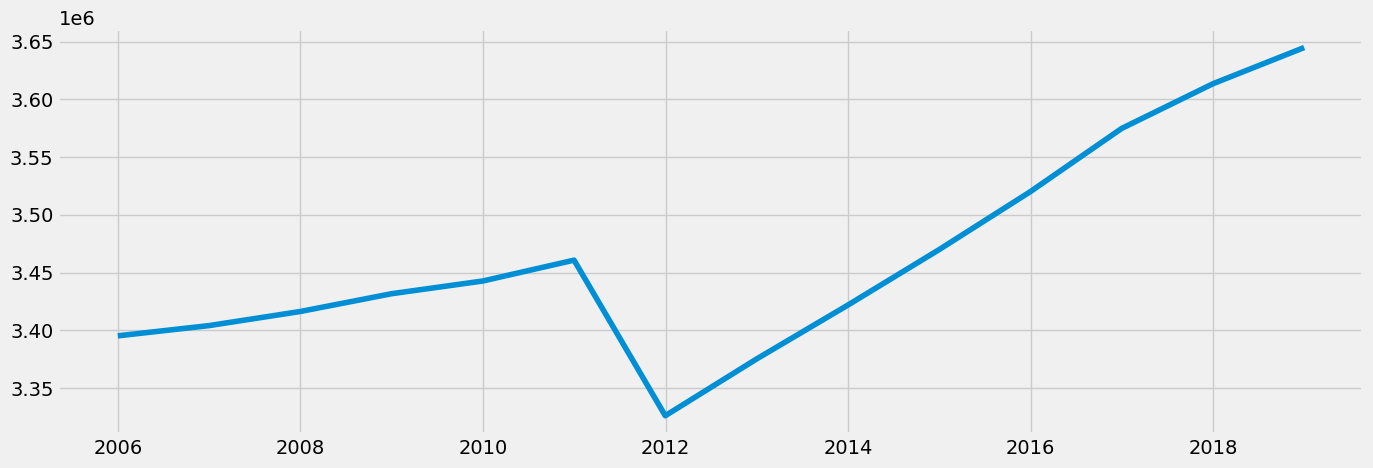

In [28]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_berlin)

### 3. Time-series analysis: decomposition

In [29]:
decomposition = sm.tsa.seasonal_decompose(df_berlin, model='additive')

In [30]:
from pylab import rcParams

In [31]:
rcParams['figure.figsize']=18,7

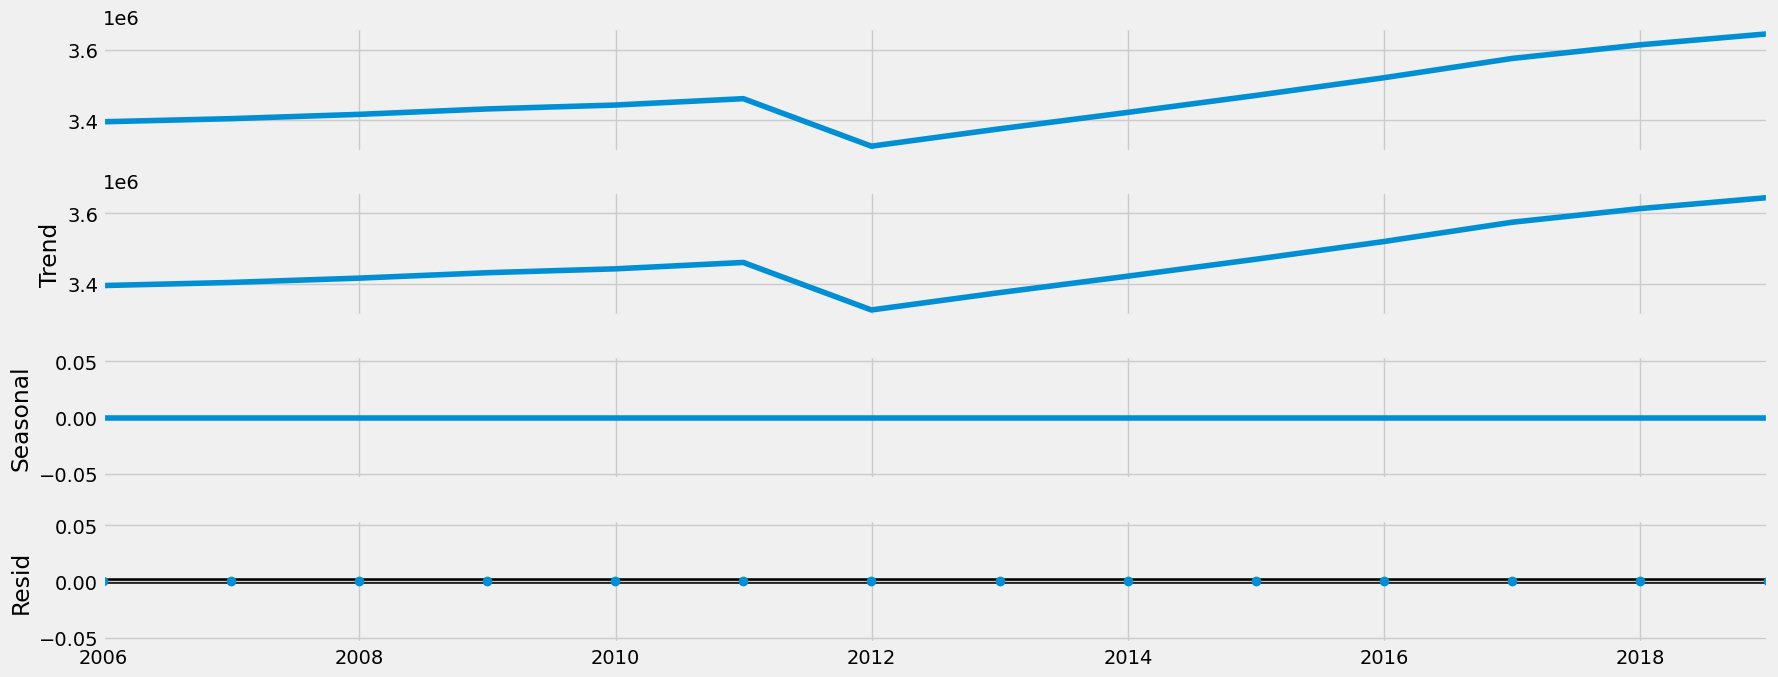

In [32]:
decomposition.plot()
plt.show()

The decomposition chart above shows that the data has a trend, but no visible seasonal or noise patterns.

### 4. Testing for stationarity

In [33]:
from statsmodels.tsa.stattools import adfuller

In [34]:
def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], 
            index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print(result)
    
dickey_fuller(df_berlin['population'])

Dickey-Fuller Stationarity test:
Test Statistic                  0.032459
p-value                         0.961135
Number of Lags Used             0.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64


##### Null hypothesis
There is a unit root within the datapoints.
##### Alternative hypothesis
There is no unit root within the datapoints.

The test statistic value(0.03) is much larger than the critical value 5% (-3.13). This means I can't reject the null hypothesis, and the data isn't stationary. 

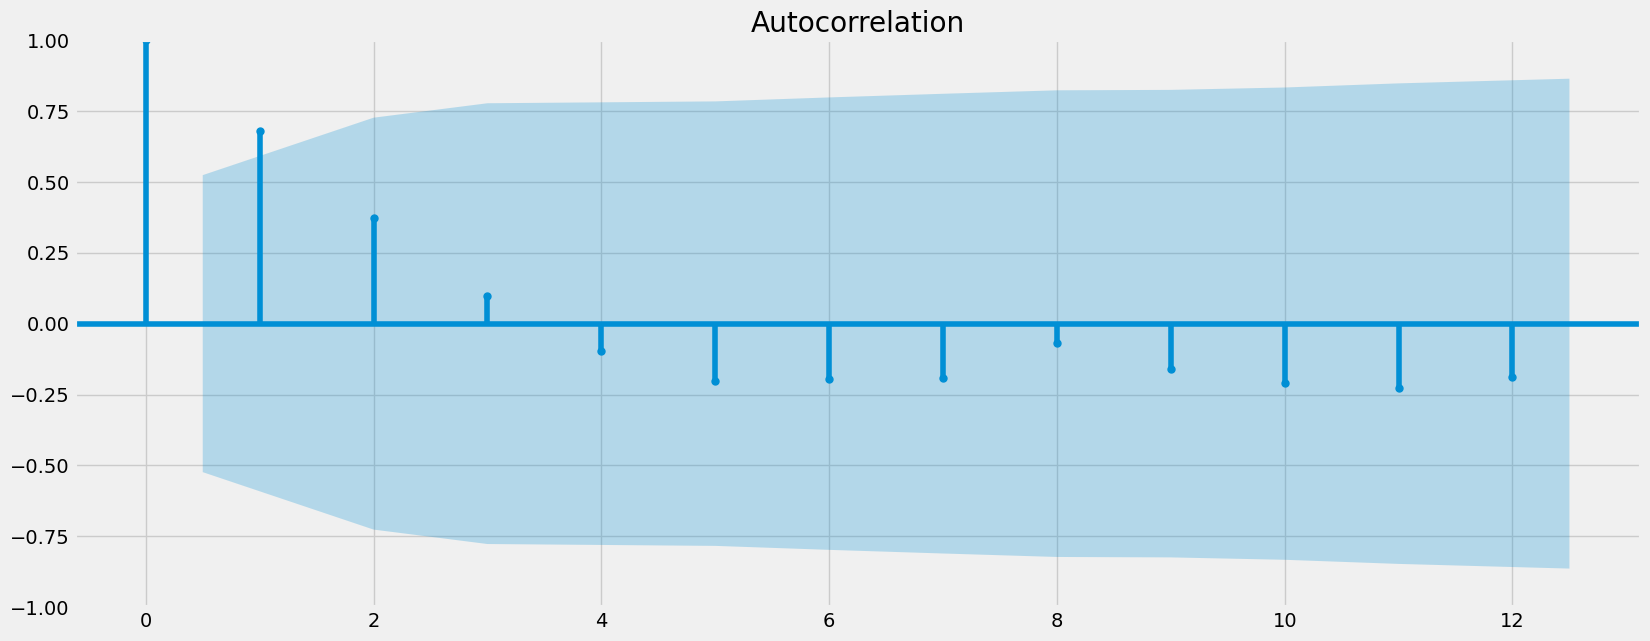

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_berlin)
plt.show()

However, the autocorrelation test shows only 2 lags beyond the interval. This indicates that the data is already stationary. It is confusing, but I will still do a round of differencing.

### 5. Stationarizing the data

##### Round 1

In [36]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
df_diff = df_berlin - df_berlin.shift(1) 

In [38]:
# Remove the missing values that came about as a result of the differencing. 
df_diff.dropna(inplace = True) 

In [39]:
df_diff.head()

,population
date,
2006-12-31,8848.0
2007-12-31,12218.0
2008-12-31,15420.0
2009-12-31,11000.0
2010-12-31,18050.0


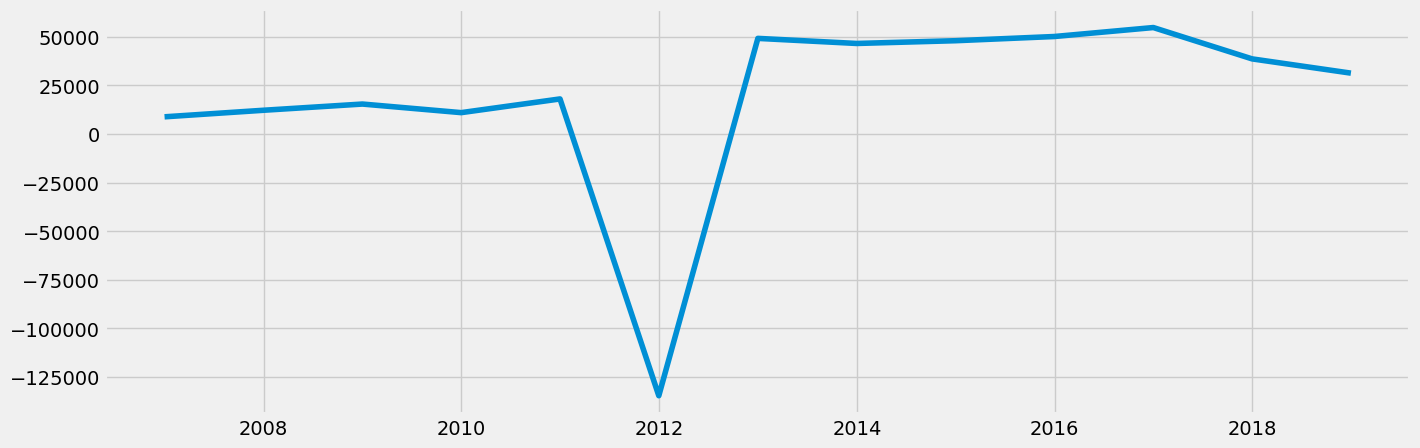

In [40]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [41]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.133529
p-value                         0.024169
Number of Lags Used             0.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


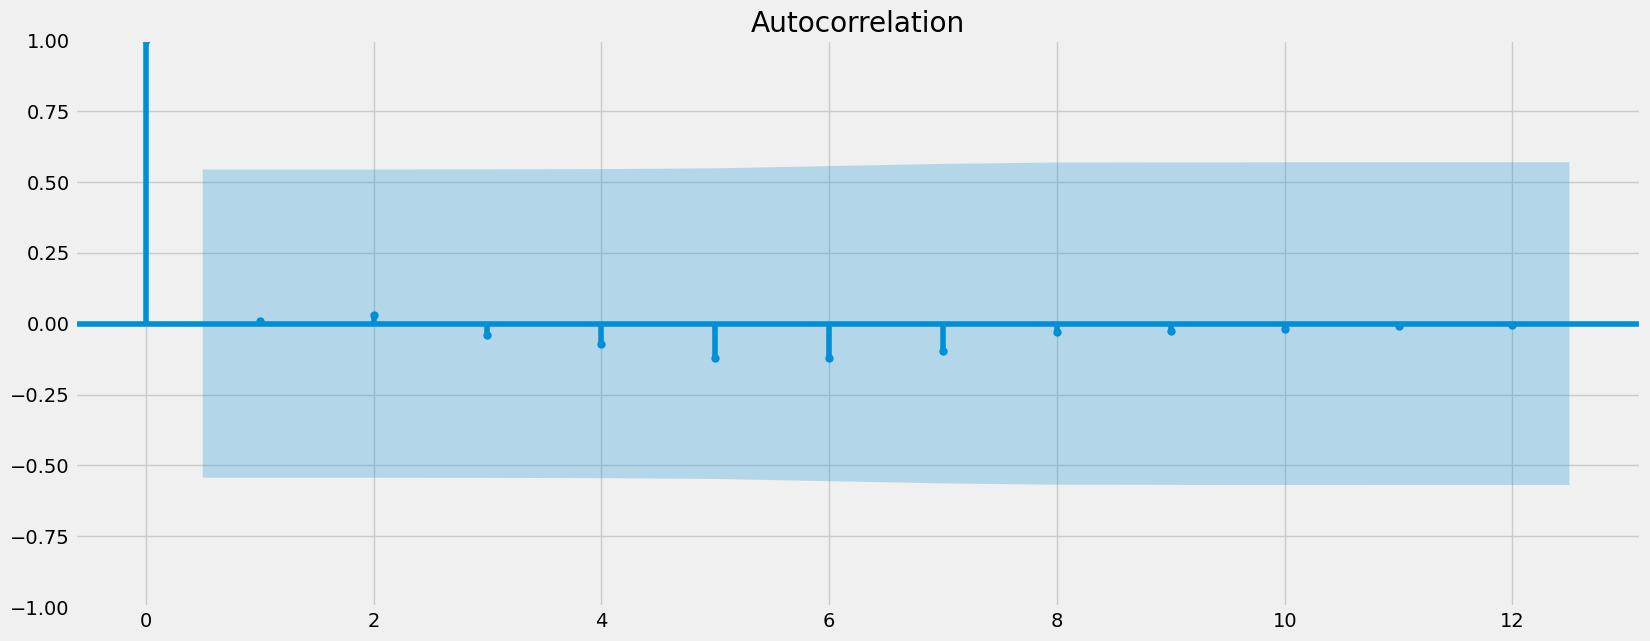

In [42]:
plot_acf(df_diff)
plt.show()

##### Null hypothesis
There is a unit root within the datapoints.

##### Alternative hypothesis
There is no unit root within the datapoints.

The test statistic value(-3.13) is a little bit larger than the critical value 5% (-3.15). Even though the autocorrelation test shows again a non-stationarity, I still can't reject the null hypothesis, and I need to perform a second round of differencing.

##### Round 2

In [43]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
df_diff_2 = df_diff - df_diff.shift(1)

In [44]:
# Remove the missing values that came about as a result of the differencing. 
df_diff_2.dropna(inplace = True)

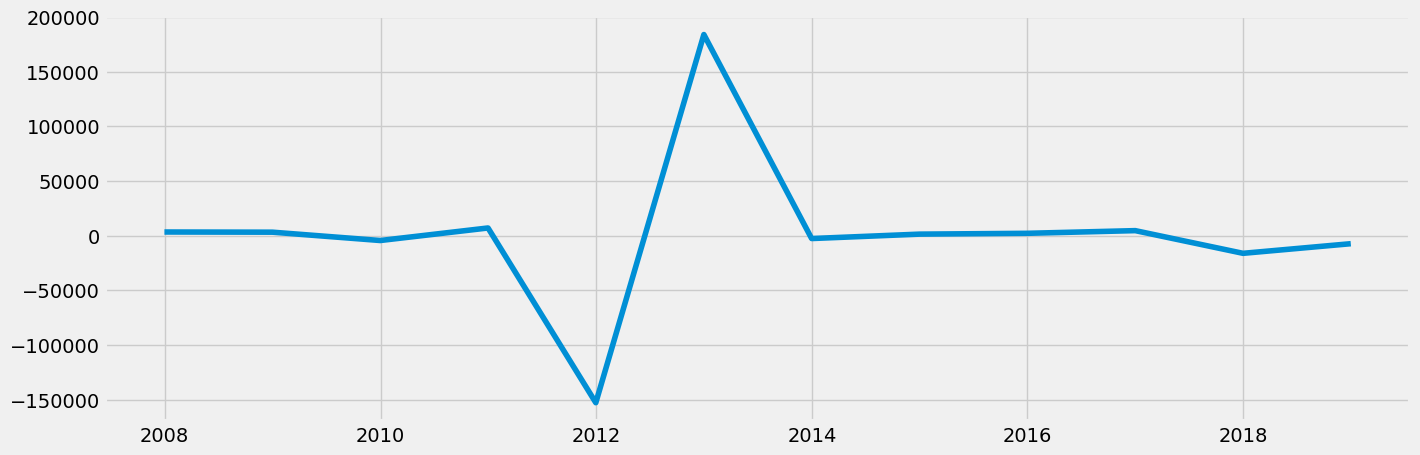

In [45]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff_2)

In [47]:
dickey_fuller(df_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -2.651164
p-value                        0.082877
Number of Lags Used            4.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64


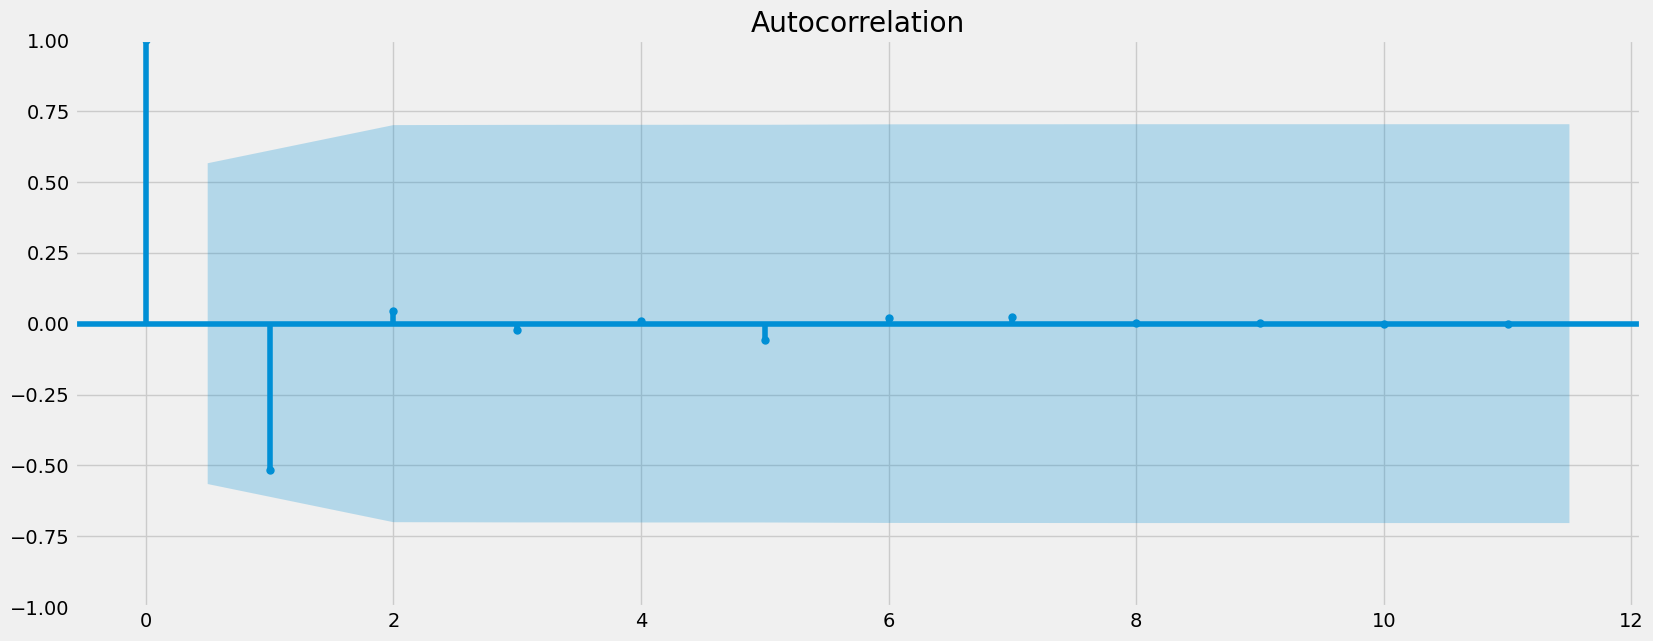

In [48]:
plot_acf(df_diff_2)
plt.show()

Now, the test statistic value(-2.65) is a smaller than the critical value 5% (-3.48). The autocorrelation test shows again a non-stationarity. The null hypothesis can be rejected now, the data is stationary.